## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [1]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "villa_database_with_embeddings.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


(65608, 1536)

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [2]:
from sklearn.cluster import KMeans

n_clusters = 65

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels


/home/sam/anaconda3/envs/Python39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
df.columns

Index(['cprcode', 'pr_engname', 'pr_name', 'combined', 'n_tokens', 'embedding',
       'Cluster'],
      dtype='object')

In [3]:
df["Cluster"]

0         5
1        30
2        21
3        18
4        45
         ..
65603    13
65604    25
65605    64
65606    28
65607    52
Name: Cluster, Length: 65608, dtype: int32

In [13]:
df.groupby("Cluster")

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

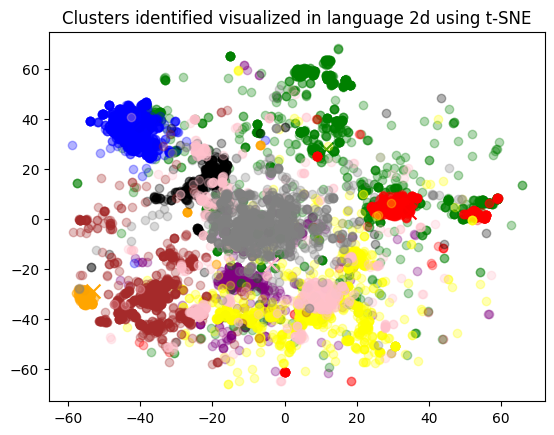

In [6]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "orange", "yellow", "black", "brown", "pink", "gray"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use davinci-instruct-beta-v3 to name the clusters, based on a random sample of 6 reviews from that cluster.

In [14]:
import openai
openai.api_key = "put_api_key_here"
# Reading a review which belong to each group.
rev_per_cluster = 50

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")
    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What types of products are these\n\nItems:\n"""\n{reviews}\n"""',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

Cluster 0 Theme: 

RateLimitError: You exceeded your current quota, please check your plan and billing details.

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.